**Using LSTM, Solve this regression problem.
Given the number of airline passengers (in thousands per month) this month, what is the
number of airline passengers (in thousands per month) next month? State your
observations on the RMSE calculated over the training and test datasets in comparison to
the original dataset.**

**Solution : Loaded the dataset monthly_milk_production.csv . Gone through the
code and corresponding texts to understand each step and the interpretation of the final outcome. Also tried to reproduce the results successfully. Now working on AirPassengers.csv as per the question.**

In [ ]:
pip install tensorflow

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [ ]:
# fix random seed for reproducibility
tf.random.set_seed(7)


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving AirPassengers.csv to AirPassengers.csv


In [ ]:
df = pd.read_csv('AirPassengers.csv',
                 index_col='Month',
                 parse_dates=True)


In [ ]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<Axes: xlabel='Month'>

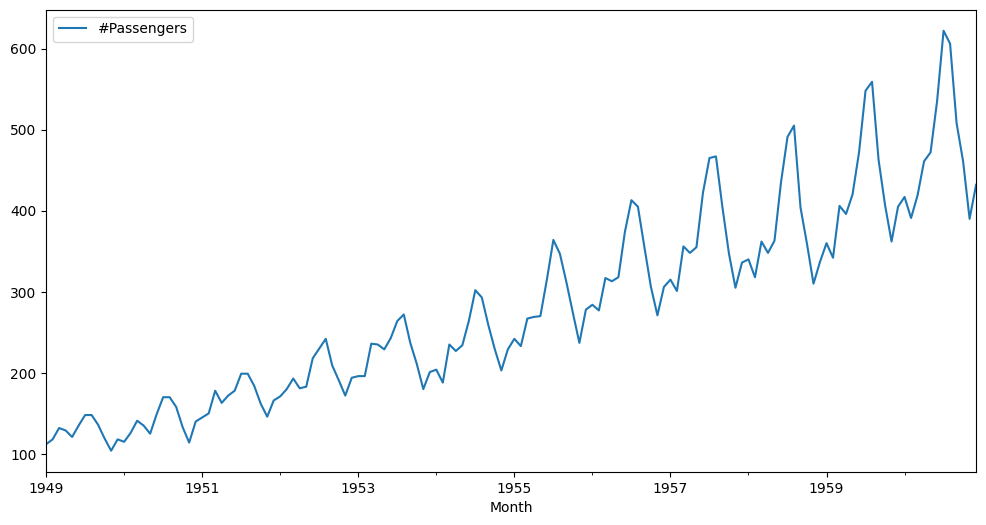

In [ ]:
# Plotting graph b/w production and date
df.plot(figsize=(12, 6))

(<Figure size 640x480 with 4 Axes>, None)

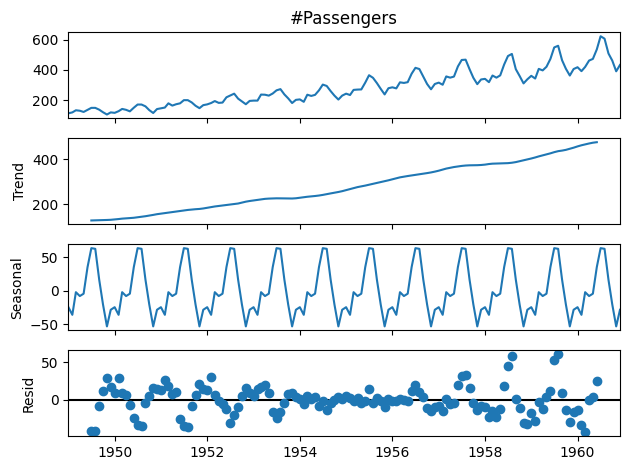

In [ ]:
#Seasonal analysis of time series data
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['#Passengers'])
results.plot(), plt.tight_layout()

In [ ]:
#Conversion of the integer values to floating-point values, as these are more suitable for modeling with a neural network.
dataset = df.values
dataset = dataset.astype('float32')


In [ ]:
# normalize the dataset, As LSTMs are considered sensitive to the scale of the input data with activation functions like sigmoid (default) or tanh, it can be better to rescale the data to the range of 0-to-1, also known as normalizing.
# We can easily normalize the dataset using the MinMaxScaler preprocessing class, which belongs to the scikit-learn library.
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
# split into train and test sets, in the case of time series data, there is a great importance of the sequence of values.
#Therefore, let us split the ordered dataset into train and test datasets by calculating the index of the split point and separating the data into the training datasets.
#Here, 67% of the observations are used to train the model, leaving the remaining 33% for testing the model.
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


96 48


Now, let us define a function for creating a new dataset, where the function takes two arguments: the dataset (for converting the NumPy array into a dataset) and the look_back (the number of previous time steps to use as input variables for predicting the next time period).

This default will create a dataset where X is the number of passengers at a given time (t), and Y is the number of passengers at the next time (t + 1).

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
  a = dataset[i:(i+look_back), 0]
  dataX.append(a)
  dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)


In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

We have to provide the input data (X) in the form of [samples, time steps, features] to the LSTM network. The present form of the data is [samples, features]. Here, we have to add a one-time step for each sample as per the problem we are addressing with the help of numpy.reshape().

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Let us design the LSTM network in the following manner to fit with the given problem: a visible layer with 1 input, a hidden layer with 4 LSTM blocks, and an output layer that makes a single value prediction. The LSTM blocks have used the default sigmoid activation function. We train the network for 100 epochs, and here we use a batch size of 1.

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
model.summary()

Epoch 1/100
94/94 - 3s - loss: 0.0294 - 3s/epoch - 31ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0138 - 189ms/epoch - 2ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0109 - 184ms/epoch - 2ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0099 - 177ms/epoch - 2ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0091 - 185ms/epoch - 2ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0079 - 174ms/epoch - 2ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0070 - 203ms/epoch - 2ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0061 - 215ms/epoch - 2ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0054 - 263ms/epoch - 3ms/step
Epoch 10/100
94/94 - 0s - loss: 0.0045 - 255ms/epoch - 3ms/step
Epoch 11/100
94/94 - 0s - loss: 0.0038 - 283ms/epoch - 3ms/step
Epoch 12/100
94/94 - 0s - loss: 0.0033 - 257ms/epoch - 3ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0029 - 266ms/epoch - 3ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0026 - 261ms/epoch - 3ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0023 - 304ms/epoch - 3ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0022 - 202ms/epoc

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


2/2 [==============================] - 0s 11ms/step
Train Score: 22.62 RMSE
Test Score: 50.05 RMSE


Observation : We observe that the model has an average error of about 23( rounded figure) air passengers (in thousand units per month) on the training dataset and about 50 air passengers (in thousand units per month) on the test dataset.

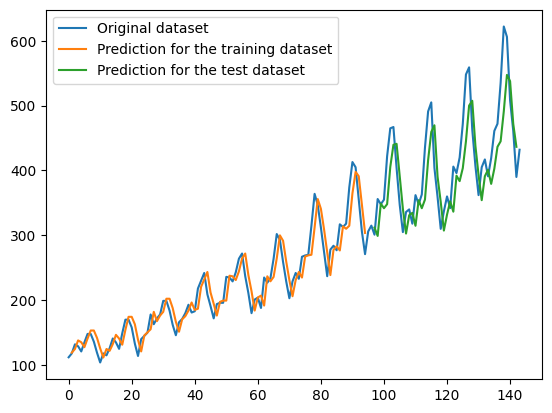

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(["Original dataset", "Prediction for the training dataset", "Prediction for the test dataset"], loc ="upper left")
plt.show()

Observation : The above plot shows the original dataset in blue, the predictions for the training dataset in saffron, and the predictions for the unseen test dataset in green.

In [ ]:
# Predict the next month Air Passenger
next_month = model.predict(np.array([test[-1]]).reshape(1, 1, 1))
next_month = scaler.inverse_transform(next_month)
print('Predicted Air Passengers for the next month:', next_month[0, 0])


1/1 [==============================] - 0s 35ms/step
Predicted Air Passengers for the next month: 413.42606


-------------------------------------------------------------------------------------------

**Observations:**

Here we were given Air passenger dataset .


- At first, loaded the dataset monthly_milk_production.csv . Gone through the
code and corresponding texts to understand each step and the interpretation of the final outcome. Also tried to reproduce the results successfully.

- Now, in similar way, Air passenger dataset has been loaded, checked its structure, and performed necessary data preprocessing steps such as converting data types and scaling.

- The LSTM model was designed with a single LSTM layer containing 4 units, followed by a dense output layer for regression. It was trained using the Adam optimizer for 100 epochs with a batch size of 1.

- Training RMSE: The model achieved a training RMSE of 22.62, indicating a relatively good fit to the training data. Model has learnt underlying patterns and relationships of training data well.

- Test RMSE: The test RMSE was calculated to be 50.05. While this value is higher than the training RMSE, it is still relatively low, suggesting that the model generalizes to unseen data.  However, it's not as accurate as it is on the training data.

- The fact that the test RMSE is higher than the training RMSE is indeed an indicator of overfitting, although it doesn't seem to be severe.

- Comparing the RMSE values to the original dataset, the model appears to provide reasonable predictions for the number of airline passengers for the next month.



**Conclusion:**

The LSTM model shows that we can predict future airline passenger numbers. Predicted Airline passengers for next month is 413 (in thousands per month).While the test RMSE is higher than the training RMSE, it remains at a reasonable level. We can conclude that the model shows potential in making predictions, but there is room for improvement in terms of generalization to unseen data. Also, further fine-tuning and optimization of hyperparameters may lead to even more accurate predictions.
